### Two connected nodes

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_amplitude_encoding/")

In [2]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm

from src.models import simulate, simulate_delayed

In [3]:
jax.config.update("jax_platform_name", "cpu")

#### Simulation parameters

In [4]:
Nareas = 2
ntrials = 200
fsamp = 1 / 1e-4

time = np.arange(-4, 4, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 20

C = np.array([[0, 1], [1, 0]]).T

f = 40

In [5]:
C

array([[0, 1],
       [1, 0]])

In [6]:
Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= 0) & (time <= 0.4)] = 0.1
Amplitudes = np.linspace(0, 0.1, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

In [7]:
simulate_loop = jax.vmap(
    simulate, in_axes=(None, None, None, None, None, None, None, 0, 0, None, None, None)
)

In [8]:
out = simulate_loop(
    C,
    5,
    np.array([20, 20]),
    np.array([-5, -5]),
    fsamp,
    beta,
    Npoints,
    CS,
    seeds,
    "cpu",
    decim,
    "both",
)

In [9]:
"""
out = []
for trial in tqdm(range(ntrials)):
    out += [
        simulate(
            C,
            1,
            np.array([40, 20]),
            np.array([-5, -1]),
            fsamp,
            beta,
            Npoints,
            CS[trial],
            seeds[trial],
            decim=decim,
            stim_mode="both",
        )
    ]
""";

In [10]:
stim = np.arange(ntrials)
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(stim, ["x", "y"], time[::decim]),
).sel(times=slice(-2, 4))

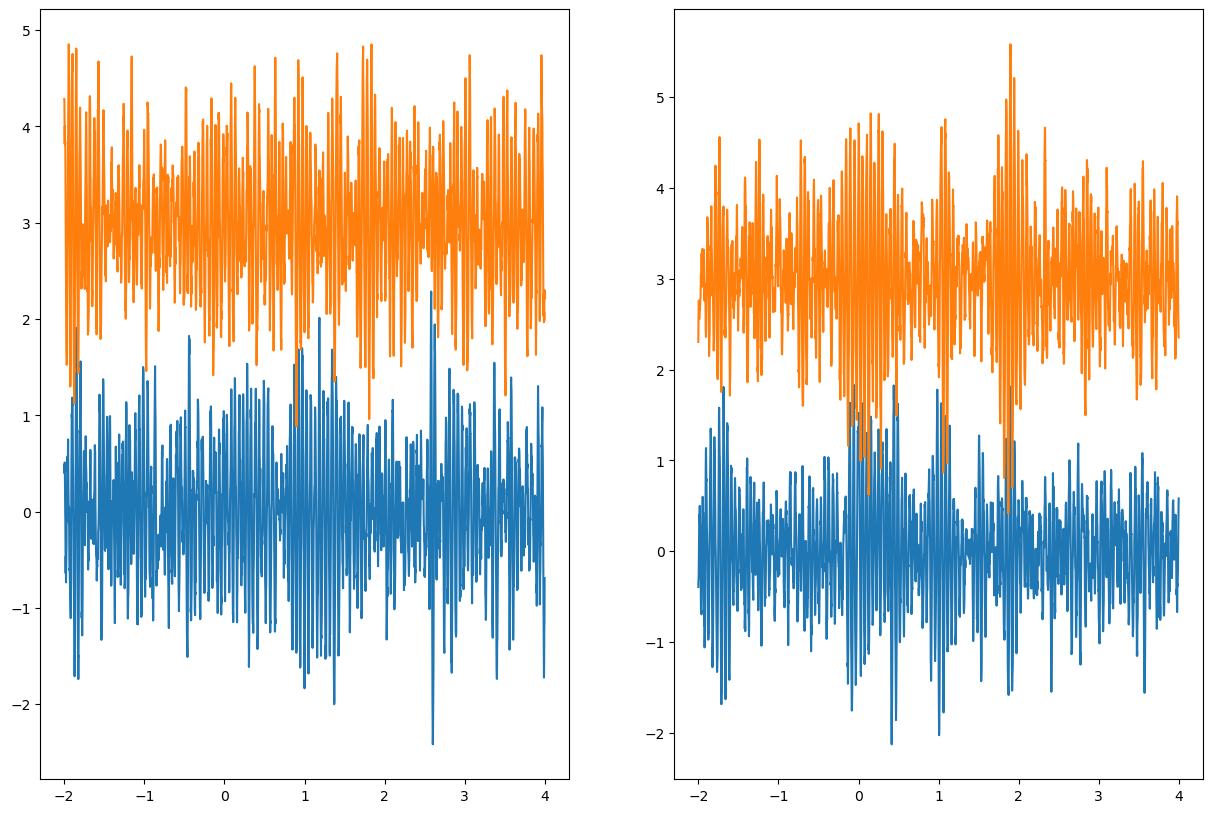

In [11]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

In [12]:
import scipy
from frites.core import (
    copnorm_nd,
    gccmi_nd_ccc,
    gcmi_1d_cc,
    gcmi_model_nd_cd,
    gcmi_nd_cc,
)

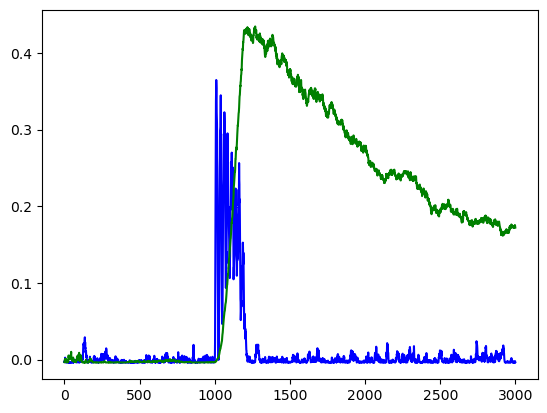

In [13]:
labels = np.tile(np.expand_dims(Amplitudes, 1), data.sizes["times"])
z = data[:, 0] * np.conj(data[:, 1])
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

I_S_R1 = gcmi_nd_cc(A, labels, traxis=0)
I_S_R2 = gcmi_nd_cc(dphi, labels, traxis=0)


plt.plot(I_S_R1, "b")
plt.plot(I_S_R2, "g")

#### Sweep parameter space

In [14]:
# For the node receiving the input
f = 40
a = -5

a_list = np.linspace(-10, 2, 20)
f_list = np.linspace(60, 10, 20)

PAI = np.zeros((len(a_list), len(f_list)))

labels = np.tile(np.expand_dims(Amplitudes, 1), data.sizes["times"])

In [15]:
pos = 1
PAI = []

for i, a_ in enumerate(a_list):
    print(pos, a_)
    out = simulate_loop(
        C,
        1,
        np.array([f, f]),
        np.array([a, a_]),
        fsamp,
        beta,
        Npoints,
        CS,
        seeds,
        "cpu",
        decim,
        "both",
    )

    stim = np.arange(ntrials)
    data = xr.DataArray(
        np.stack(out),
        dims=("trials", "roi", "times"),
        coords=(stim, ["x", "y"], time[::decim]),
    ).sel(times=slice(-2, 4))

    z = data[:, 0] * np.conj(data[:, 1])
    A = np.abs(z).values
    dphi = np.unwrap(np.angle(z))

    I_S_R1 = gcmi_nd_cc(A, labels, traxis=0)
    I_S_R2 = gcmi_nd_cc(dphi, labels, traxis=0)

    PAI += [np.trapz(I_S_R2 - I_S_R1, dx=np.diff(data.times.values)[0])]

    pos = pos + 1

1 -10.0
2 -9.368421052631579
3 -8.736842105263158
4 -8.105263157894736
5 -7.473684210526316
6 -6.842105263157895
7 -6.210526315789474
8 -5.578947368421053
9 -4.947368421052632
10 -4.315789473684211
11 -3.6842105263157894
12 -3.052631578947369
13 -2.421052631578948
14 -1.7894736842105274
15 -1.1578947368421062
16 -0.526315789473685
17 0.10526315789473628
18 0.7368421052631575
19 1.3684210526315788
20 2.0


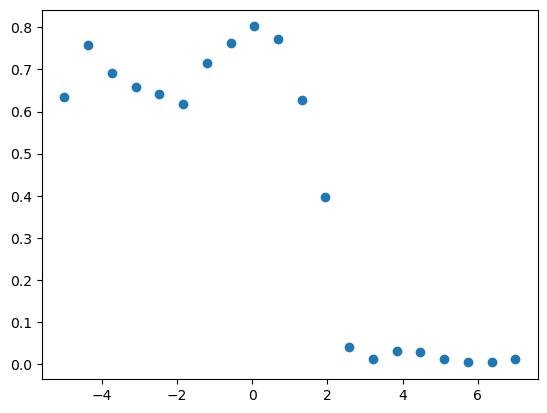

In [17]:
plt.scatter(a_list - a, PAI)

In [18]:
pos = 1
PAIf = []

for i, f_ in enumerate(f_list):
    print(pos, f_)
    out = simulate_loop(
        C,
        1,
        np.array([f, f_]),
        np.array([a, a]),
        fsamp,
        beta,
        Npoints,
        CS,
        seeds,
        "cpu",
        decim,
        "both",
    )

    stim = np.arange(ntrials)
    data = xr.DataArray(
        np.stack(out),
        dims=("trials", "roi", "times"),
        coords=(stim, ["x", "y"], time[::decim]),
    ).sel(times=slice(-2, 4))

    z = data[:, 0] * np.conj(data[:, 1])
    A = np.abs(z).values
    dphi = np.unwrap(np.angle(z))

    I_S_R1 = gcmi_nd_cc(A, labels, traxis=0)
    I_S_R2 = gcmi_nd_cc(dphi, labels, traxis=0)

    PAIf += [np.trapz(I_S_R2 - I_S_R1, dx=np.diff(data.times.values)[0])]

    pos = pos + 1

1 60.0
2 57.368421052631575
3 54.73684210526316
4 52.10526315789474
5 49.473684210526315
6 46.84210526315789
7 44.21052631578947
8 41.578947368421055
9 38.94736842105263
10 36.315789473684205
11 33.68421052631579
12 31.052631578947366
13 28.421052631578945
14 25.78947368421052
15 23.157894736842103
16 20.526315789473685
17 17.89473684210526
18 15.263157894736835
19 12.631578947368418
20 10.0


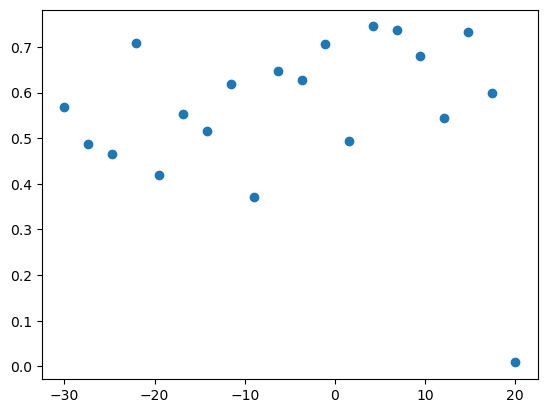

In [19]:
plt.scatter(f_list - f, PAIf)

In [15]:
pos = 1
for i, a_ in enumerate(a_list):
    for j, f_ in enumerate(f_list):
        print(pos, a_, f_)
        out = simulate_loop(
            C,
            5,
            np.array([f, f_]),
            np.array([a, a_]),
            fsamp,
            beta,
            Npoints,
            CS,
            seeds,
            "cpu",
            decim,
            "both",
        )

        stim = np.arange(ntrials)
        data = xr.DataArray(
            np.stack(out),
            dims=("trials", "roi", "times"),
            coords=(stim, ["x", "y"], time[::decim]),
        ).sel(times=slice(-2, 4))

        z = data[:, 0] * np.conj(data[:, 1])
        A = np.abs(z).values
        dphi = np.unwrap(np.angle(z))

        I_S_R1 = gcmi_nd_cc(A, labels, traxis=0)
        I_S_R2 = gcmi_nd_cc(dphi, labels, traxis=0)

        PAI[i, j] = np.trapz(I_S_R2 - I_S_R1, dx=np.diff(data.times.values)[0])

        pos = pos + 1

1 -10.0 60.0
2 -10.0 57.368421052631575
3 -10.0 54.73684210526316
4 -10.0 52.10526315789474
5 -10.0 49.473684210526315
6 -10.0 46.84210526315789
7 -10.0 44.21052631578947
8 -10.0 41.578947368421055
9 -10.0 38.94736842105263
10 -10.0 36.315789473684205
11 -10.0 33.68421052631579
12 -10.0 31.052631578947366
13 -10.0 28.421052631578945
14 -10.0 25.78947368421052
15 -10.0 23.157894736842103
16 -10.0 20.526315789473685
17 -10.0 17.89473684210526
18 -10.0 15.263157894736835
19 -10.0 12.631578947368418
20 -10.0 10.0
21 -9.368421052631579 60.0
22 -9.368421052631579 57.368421052631575
23 -9.368421052631579 54.73684210526316
24 -9.368421052631579 52.10526315789474
25 -9.368421052631579 49.473684210526315
26 -9.368421052631579 46.84210526315789
27 -9.368421052631579 44.21052631578947
28 -9.368421052631579 41.578947368421055
29 -9.368421052631579 38.94736842105263
30 -9.368421052631579 36.315789473684205
31 -9.368421052631579 33.68421052631579
32 -9.368421052631579 31.052631578947366
33 -9.3684210

Text(0.5, 0, '$\\Delta$ f')

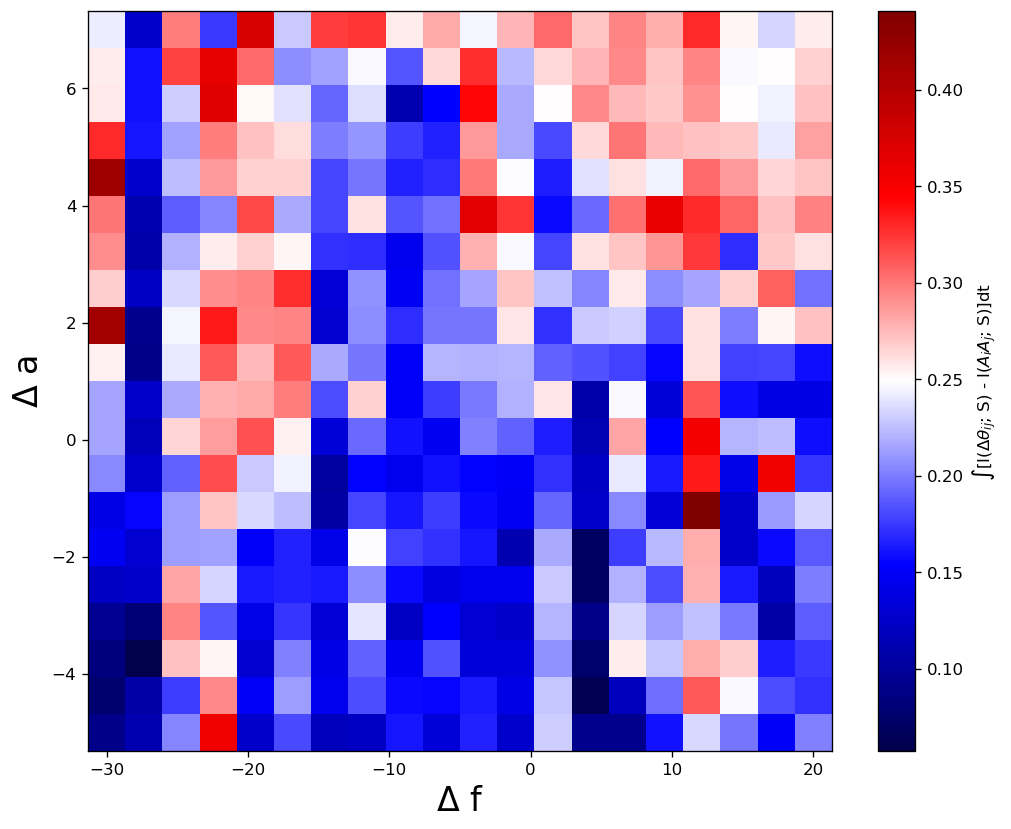

In [26]:
plt.figure(figsize=(10, 8), dpi=120)
PAIxr = xr.DataArray(PAI, dims=("a", "f"), coords=(a_list - a, f_list - f))
PAIxr.plot(
    cmap="seismic",
    cbar_kwargs={"label": r"$\int$[I($\Delta\theta_{ij}$; S) - I($A_iA_j$; S)]dt"},
)
plt.ylabel(r"$\Delta$ a", fontsize=20)
plt.xlabel(r"$\Delta$ f", fontsize=20)

0.2853668700452955


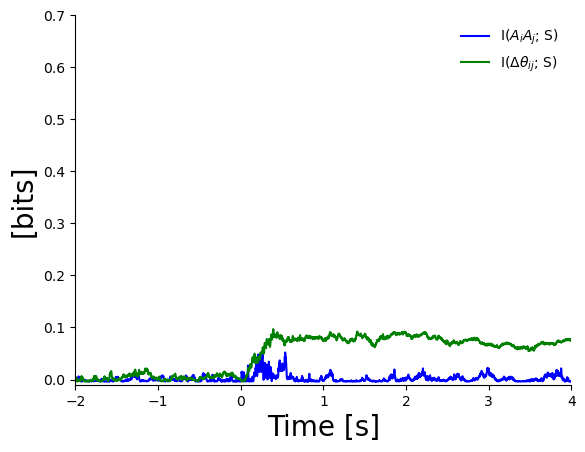

In [29]:
out = simulate_loop(
    C,
    5,
    np.array([f, f]),
    np.array([a, a]),
    fsamp,
    beta,
    Npoints,
    CS,
    seeds,
    "cpu",
    decim,
    "both",
)

stim = np.arange(ntrials)
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(stim, ["x", "y"], time[::decim]),
).sel(times=slice(-2, 4))


z = data[:, 0] * np.conj(data[:, 1])
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

I_S_R1 = gcmi_nd_cc(A, labels, traxis=0)
I_S_R2 = gcmi_nd_cc(dphi, labels, traxis=0)

ax = plt.subplot(111)
plt.plot(data.times, I_S_R1, "b")
plt.plot(data.times, I_S_R2, "g")
plt.legend([r"I($A_iA_j$; S)", r"I($\Delta\theta_{ij}$; S)"], frameon=False)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("[bits]", fontsize=20)
plt.xlim(-2, 4)
plt.ylim(-0.01, 0.7)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

print(np.trapz(I_S_R2 - I_S_R1, dx=np.diff(data.times.values)[0]))

In [20]:
dphi0 = dphi.copy()

0.19370612629427708


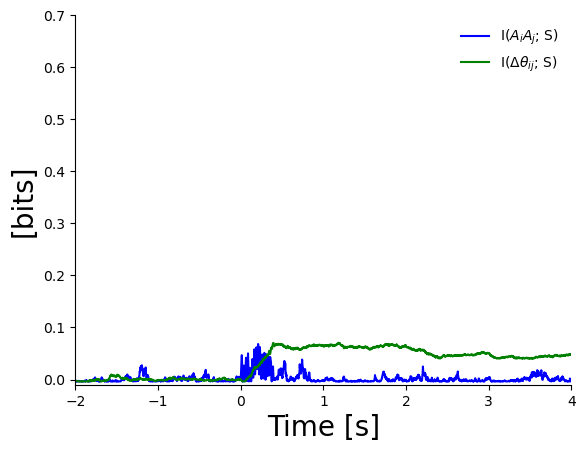

In [28]:
out = simulate_loop(
    C,
    5,
    np.array([f, 30]),
    np.array([a, 1]),
    fsamp,
    beta,
    Npoints,
    CS,
    seeds,
    "cpu",
    decim,
    "both",
)

stim = np.arange(ntrials)
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(stim, ["x", "y"], time[::decim]),
).sel(times=slice(-2, 4))


z = data[:, 0] * np.conj(data[:, 1])
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

I_S_R1 = gcmi_nd_cc(A, labels, traxis=0)
I_S_R2 = gcmi_nd_cc(dphi, labels, traxis=0)

ax = plt.subplot(111)
plt.plot(data.times, I_S_R1, "b")
plt.plot(data.times, I_S_R2, "g")
plt.legend([r"I($A_iA_j$; S)", r"I($\Delta\theta_{ij}$; S)"], frameon=False)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("[bits]", fontsize=20)
plt.xlim(-2, 4)
plt.ylim(-0.01, 0.7)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

print(np.trapz(I_S_R2 - I_S_R1, dx=np.diff(data.times.values)[0]))

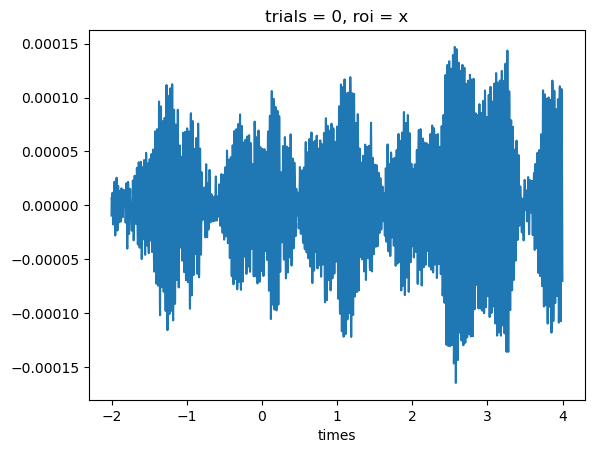

In [22]:
data[0, 0].real.plot()

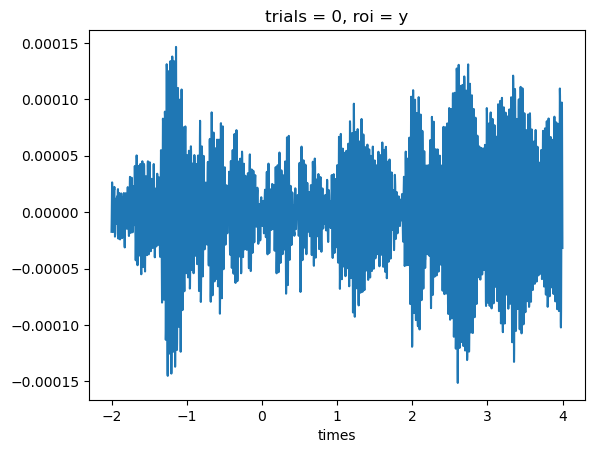

In [23]:
data[0, 1].real.plot()

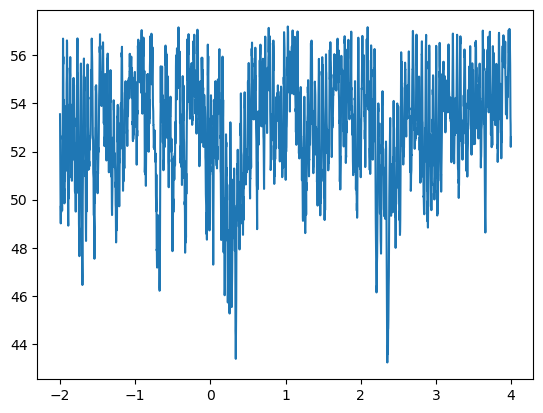

In [24]:
plt.plot(data.times, scipy.stats.circvar(dphi0, axis=0) * 180 / np.pi)

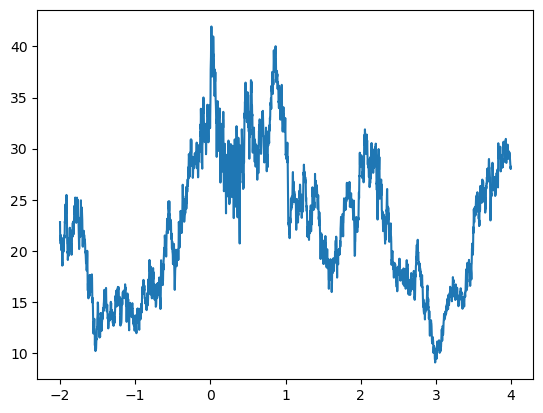

In [25]:
plt.plot(data.times, scipy.stats.circvar(dphi, axis=0) * 180 / np.pi)